#### Imports

In [ ]:
import numpy as np
import pandas as pd
import umap
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


# Embeddings must be [n_papers, emb_dim], one .npy file per model
emb_files = {
    'A': '/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/BAAI*bge-large-en-v1.5/embeddings.npy',
    'B': '/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/sentence-transformers*all-MiniLM-L6-v2/embeddings.npy',
    'C': '/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/sentence-transformers*all-mpnet-base-v2/embeddings.npy'
}
embeddings = {k: np.load(f) for k, f in emb_files.items()}

# UMAP to 50D for clustering, 2D for plotting
umap_50d = umap.UMAP(n_components=50, metric='cosine', random_state=42)
umap_2d = umap.UMAP(n_components=2, metric='cosine', random_state=42)

reduced_50d = {k: umap_50d.fit_transform(v) for k, v in embeddings.items()}
reduced_2d = {k: umap_2d.fit_transform(v) for k, v in embeddings.items()}

In [ ]:
# ---------------------------------
# 3. Clustering (HDBSCAN)
# ---------------------------------
import hdbscan
n_clusters = 20
cluster_labels = {}
sil_scores = {}

for k in embeddings:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=200,
        min_samples=10,
        metric="euclidean",
    )
    clusterer.fit(reduced_50d[k])
    labels = clusterer.labels_
    cluster_labels[k] = clusterer.labels_
    n_clusters = len(np.unique(labels[labels != -1]))
    sil = silhouette_score(reduced_50d[k], labels)
    sil_scores[k] = sil
    print(f"Model {k} Silhouette Score: {sil:.3f}")

In [ ]:
# ---------------------------------
# 4. Compare clustering across models
# ---------------------------------
def compute_pairwise_metrics(labels_a, labels_b):
    return {
        'ARI': adjusted_rand_score(labels_a, labels_b),
        'NMI': normalized_mutual_info_score(labels_a, labels_b),
        'V-Measure': v_measure_score(labels_a, labels_b)
    }

results = {
    'A vs B': compute_pairwise_metrics(cluster_labels['A'], cluster_labels['B']),
    'A vs C': compute_pairwise_metrics(cluster_labels['A'], cluster_labels['C']),
    'B vs C': compute_pairwise_metrics(cluster_labels['B'], cluster_labels['C']),
}

metrics_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model Pair'})
print(metrics_df)

# Visualise agreement
sns.set(style="whitegrid")
melted = metrics_df.melt(id_vars='Model Pair', var_name='Metric', value_name='Score')
plt.figure(figsize=(8, 5))
sns.barplot(data=melted, x='Model Pair', y='Score', hue='Metric')
plt.title("Clustering Agreement Across Embedding Models")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


for k in reduced_2d:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=reduced_2d[k][:, 0], y=reduced_2d[k][:, 1],
        hue=cluster_labels[k], palette='tab20', s=8, linewidth=0
    )
    plt.title(f"Model {k}: UMAP 2D Projection with Clusters")
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()


for k in cluster_labels:
    np.save(f'cluster_labels_model{k}.npy', cluster_labels[k])


print("Silhouette Scores for Each Model:")
for k, v in sil_scores.items():
    print(f"Model {k}: {v:.3f}")



In [ ]:
from sklearn.preprocessing import normalize
emb_files = {
    'A': '/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/BAAI*bge-large-en-v1.5/embeddings.npy',
    'B': '/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/sentence-transformers*all-MiniLM-L6-v2/embeddings.npy',
    'C': '/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/sentence-transformers*all-mpnet-base-v2/embeddings.npy'
}

for tag, fpath in emb_files.items():
    print(f"Loading {tag} from {fpath} ...")
    X = np.load(fpath).astype("float32")
    embeddings[tag] = normalize(X)
    print(f"{tag}: shape = {X.shape}")

# retrying with low cluster size
# ---------------------------------
# 3. Clustering (HDBSCAN)
# ---------------------------------
import hdbscan
cluster_labels = {}
sil_scores = {}

for k in embeddings:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=80,
        min_samples=10,
        metric="euclidean",
    )
    clusterer.fit(reduced_50d[k])
    labels = clusterer.labels_
    cluster_labels[k] = clusterer.labels_
    n_clusters = len(np.unique(labels[labels != -1]))
    sil = silhouette_score(reduced_50d[k], labels)
    sil_scores[k] = sil
    print(f"Model {k} Silhouette Score: {sil:.3f}")

# ---------------------------------
# 4. Compare clustering across models
# ---------------------------------
def compute_pairwise_metrics(labels_a, labels_b):
    return {
        'ARI': adjusted_rand_score(labels_a, labels_b),
        'NMI': normalized_mutual_info_score(labels_a, labels_b),
        'V-Measure': v_measure_score(labels_a, labels_b)
    }

results = {
    'A vs B': compute_pairwise_metrics(cluster_labels['A'], cluster_labels['B']),
    'A vs C': compute_pairwise_metrics(cluster_labels['A'], cluster_labels['C']),
    'B vs C': compute_pairwise_metrics(cluster_labels['B'], cluster_labels['C']),
}

metrics_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model Pair'})
print(metrics_df)

# Visualise agreement
sns.set(style="whitegrid")
melted = metrics_df.melt(id_vars='Model Pair', var_name='Metric', value_name='Score')
plt.figure(figsize=(8, 5))
sns.barplot(data=melted, x='Model Pair', y='Score', hue='Metric')
plt.title("Clustering Agreement Across Embedding Models")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


for k in reduced_2d:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=reduced_2d[k][:, 0], y=reduced_2d[k][:, 1],
        hue=cluster_labels[k], palette='tab20', s=8, linewidth=0
    )
    plt.title(f"Model {k}: UMAP 2D Projection with Clusters")
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()


for k in cluster_labels:
    np.save(f'cluster_labels_model{k}.npy', cluster_labels[k])


print("Silhouette Scores for Each Model:")
for k, v in sil_scores.items():
    print(f"Model {k}: {v:.3f}")




Unique labels in Model B: [-1  0  1]


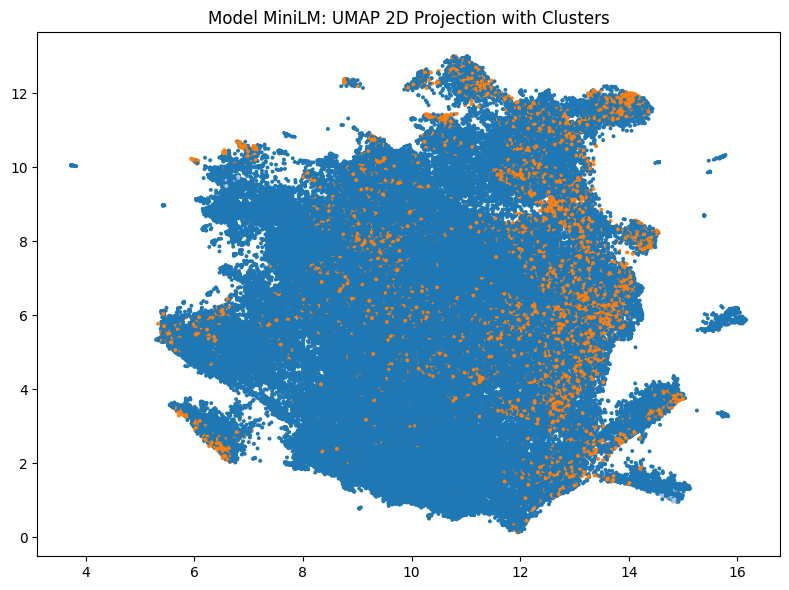

In [2]:
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import umap

labels = np.load(f'cluster_labels_modelB_l.npy')
unique_labels = np.unique(labels)
print(f"Unique labels in Model B: {unique_labels}")
umap_2d = umap.UMAP(n_components=2, metric='cosine', random_state=42)
# reduced_50d = {k: umap_50d.fit_transform(v) for k, v in embeddings.items()}
X = np.load('/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/sentence-transformers*all-MiniLM-L6-v2/embeddings.npy').astype("float32")
v = normalize(X)
reduced_2d = umap_2d.fit_transform(v)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced_2d[:, 0], y=reduced_2d[:, 1],
    hue=labels, palette='tab20', s=8, linewidth=0
)
plt.title(f"Model MiniLM: UMAP 2D Projection with Clusters")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

Unique labels in Model B: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168]


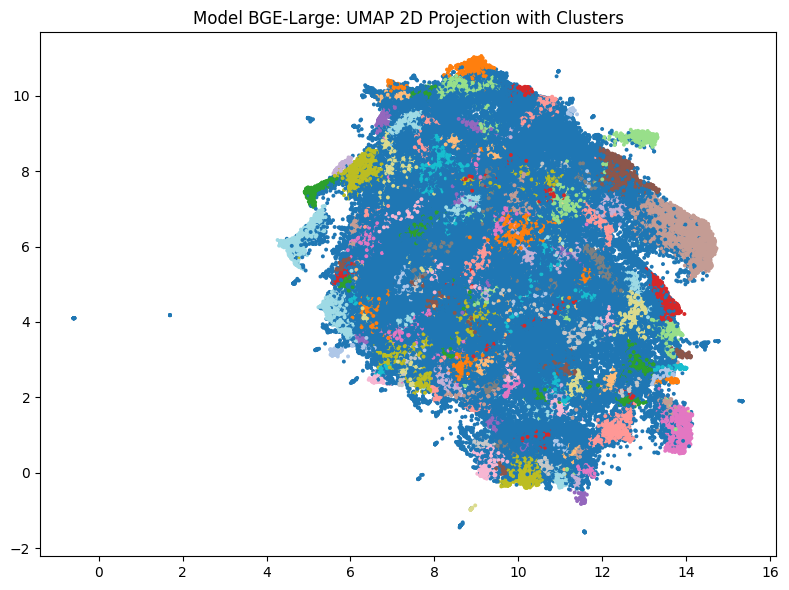

In [3]:
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import umap

labels = np.load(f'/vol/bitbucket/bp824/astro/clustering_results/hdscan/cluster_labels_modelA.npy')
unique_labels = np.unique(labels)
print(f"Unique labels in Model B: {unique_labels}")
umap_2d = umap.UMAP(n_components=2, metric='cosine', random_state=42)
# reduced_50d = {k: umap_50d.fit_transform(v) for k, v in embeddings.items()}
X = np.load('/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/BAAI*bge-large-en-v1.5/embeddings.npy').astype("float32")
v = normalize(X)
reduced_2d = umap_2d.fit_transform(v)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced_2d[:, 0], y=reduced_2d[:, 1],
    hue=labels, palette='tab20', s=8, linewidth=0
)
plt.title(f"Model BGE-Large: UMAP 2D Projection with Clusters")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

Unique labels in Model B: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209]


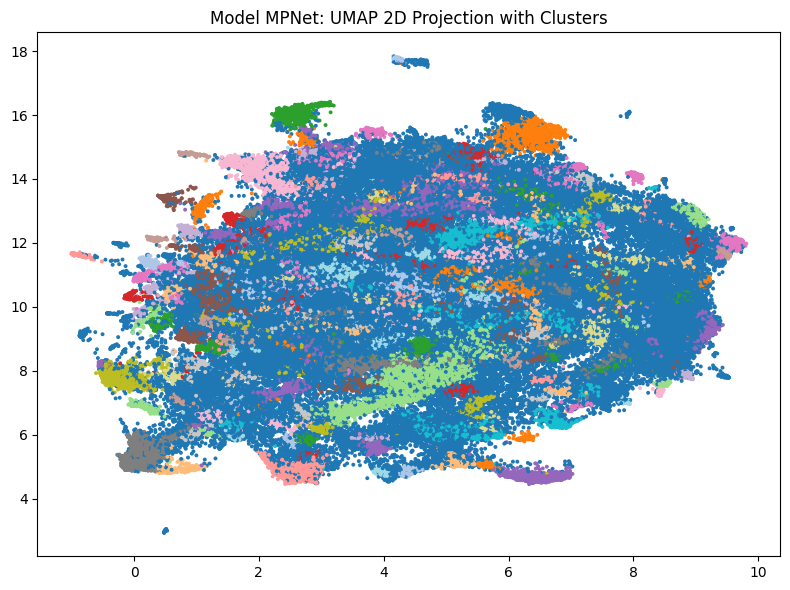

In [4]:
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import umap

labels = np.load(f'/vol/bitbucket/bp824/astro/clustering_results/hdscan/cluster_labels_modelC.npy')
unique_labels = np.unique(labels)
print(f"Unique labels in Model B: {unique_labels}")
umap_2d = umap.UMAP(n_components=2, metric='cosine', random_state=42)
# reduced_50d = {k: umap_50d.fit_transform(v) for k, v in embeddings.items()}
X = np.load('/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/sentence-transformers*all-mpnet-base-v2/embeddings.npy').astype("float32")
v = normalize(X)
reduced_2d = umap_2d.fit_transform(v)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced_2d[:, 0], y=reduced_2d[:, 1],
    hue=labels, palette='tab20', s=8, linewidth=0
)
plt.title(f"Model MPNet: UMAP 2D Projection with Clusters")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1716633/584403521.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


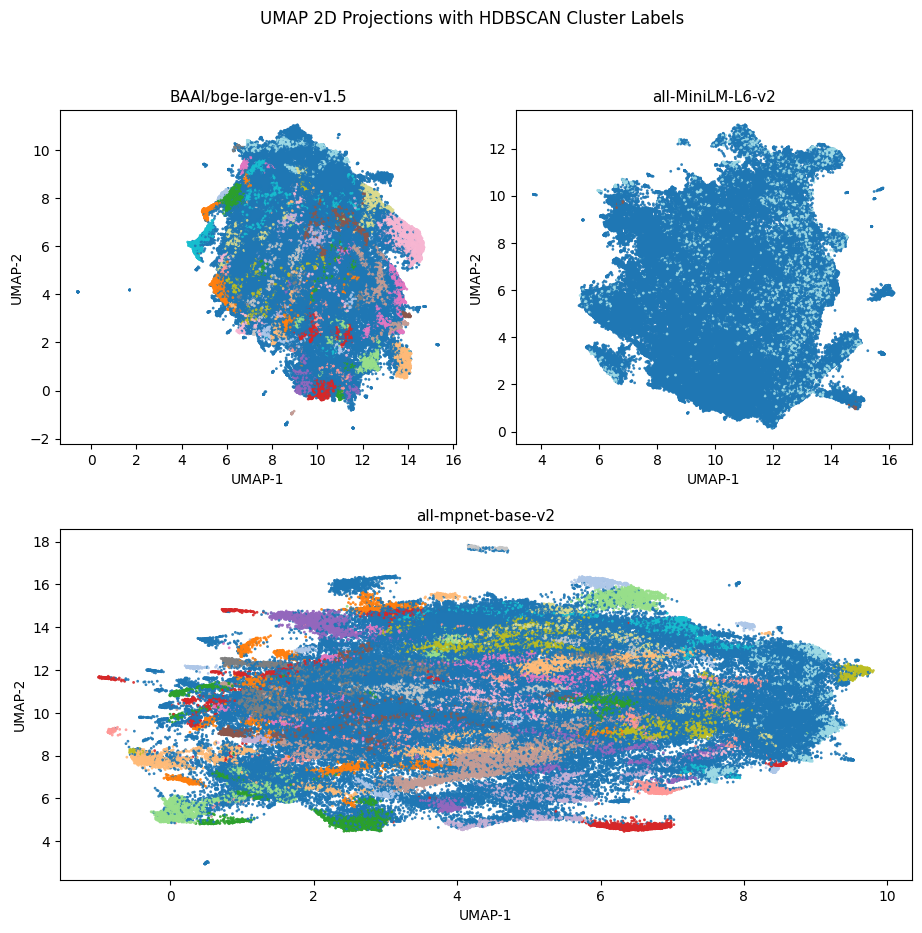

In [5]:
import glob
import numpy as np
from sklearn.preprocessing import normalize
import umap
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _resolve(path_or_glob: str) -> str:
    if "*" in path_or_glob:
        hits = glob.glob(path_or_glob)
        if not hits:
            raise FileNotFoundError(f"No files match: {path_or_glob}")
        return hits[0]
    return path_or_glob

def load_and_reduce(embed_path, label_path, random_state=42):
    X = np.load(_resolve(embed_path)).astype("float32")
    labels = np.load(_resolve(label_path))
    Xn = normalize(X)
    reducer = umap.UMAP(n_components=2, metric="cosine", random_state=random_state)
    emb2d = reducer.fit_transform(Xn)
    return emb2d, labels

def scatter_umap(ax, emb2d, labels, title):
    sc = ax.scatter(
        emb2d[:, 0], emb2d[:, 1],
        c=labels, s=4, cmap="tab20", linewidths=0, alpha=0.9, rasterized=True
    )
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    # no legend (too many classes); thesis-ready and compact
    return sc

# ---------- paths (edit if needed) ----------
p_minilm_X = "/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/sentence-transformers*all-MiniLM-L6-v2/embeddings.npy"
p_minilm_y = "cluster_labels_modelB_l.npy"

p_bge_X    = "/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/BAAI*bge-large-en-v1.5/embeddings.npy"
p_bge_y    = "/vol/bitbucket/bp824/astro/clustering_results/hdscan/cluster_labels_modelA.npy"

p_mpnet_X  = "/vol/bitbucket/bp824/astro/data/embeddings_facebook_v1/sentence-transformers*all-mpnet-base-v2/embeddings.npy"
p_mpnet_y  = "/vol/bitbucket/bp824/astro/clustering_results/hdscan/cluster_labels_modelC.npy"

# ---------- compute ----------
umap_minilm, y_minilm = load_and_reduce(p_minilm_X, p_minilm_y)
umap_bge,    y_bge    = load_and_reduce(p_bge_X,    p_bge_y)
umap_mpnet,  y_mpnet  = load_and_reduce(p_mpnet_X,  p_mpnet_y)

# ---------- layout: 2 on top, 1 below spanning both ----------
fig = plt.figure(figsize=(11, 10))
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1, 1.05], hspace=0.25, wspace=0.15)

ax1 = fig.add_subplot(gs[0, 0])      # left top
ax2 = fig.add_subplot(gs[0, 1])      # right top
ax3 = fig.add_subplot(gs[1, :])      # bottom spanning both columns

scatter_umap(ax1, umap_bge,    y_bge,    "BAAI/bge-large-en-v1.5")
scatter_umap(ax2, umap_minilm, y_minilm, "all-MiniLM-L6-v2")
scatter_umap(ax3, umap_mpnet,  y_mpnet,  "all-mpnet-base-v2")

fig.suptitle("UMAP 2D Projections with HDBSCAN Cluster Labels", fontsize=12, y=0.98)
plt.tight_layout()

# Save high-quality outputs for LaTeX
plt.savefig("umap_three_models.png", dpi=300, bbox_inches="tight")
plt.savefig("umap_three_models.pdf", dpi=300, bbox_inches="tight")  # vector + rasterized points
plt.show()
